In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from collections import deque
import random
import time 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

#=======Functions===========
# to define the target 
def classify (current, future):
    if float(future)>float(current):
        return 1
    else:
        return 0

#for preprocessing  the data and preparation of sequences
def preprocess_df(df):
    df=df.drop('future', 1) # we don't need this feature served only to define target
    for col in df.columns:
        if col!='target':
            df[col]=df[col].pct_change()  # to calculate percentage change between the current and the immediately previous row
            df.dropna(inplace=True)        # remove the Nas created by pct_change
            df[col]=preprocessing.scale(df[col].values)  #  scale between 0 and 1.
    df.dropna(inplace=True)
    sequential_data=[]   # a list that will contain sequences of data 
    prev_days=deque(maxlen=SEQ_LEN)  # These will be our actual sequences. 
                                    #Deque=> container behaving like a list with quick additions and deletions at each end

    for i in df.values:
        prev_days.append([n for n in i[:-1]]) # # append all the ligne but not the target
        if len(prev_days)==SEQ_LEN:         # only 60 sample 
          sequential_data.append([np.array(prev_days),i[-1]])
             
    random.shuffle(sequential_data) #  # shuffle for good performance
    buys = []   # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets
    for seq,target in sequential_data:
      if target==0:
        sells.append([seq,target])
      if target==1:
        buys.append([seq,target])
        
    random.shuffle (buys) # shuffle the buys
    random.shuffle (sells)
    
    lower=min(len(buys),len(sells)) # the shorter length?
    buys=buys[:lower]
    sells=sells[:lower]
    sequential_data=buys+sells  # add buys and sells together together
    random.shuffle(sequential_data)  #  shuffle, so the model doesn't get confused with all 1 class then the other.

    x=[]
    y=[]
    
    for seq, target in sequential_data: # sequential_data new sequencces data 
        x.append(seq)      # X is the sequences
        y.append(target)   # y is the targets/labels (buys vs sell/notbuy) 
    return np.array(x),y

#======Data Preparation========
SEQ_LEN=60                   # lenght of each sequence 
FUTURE_PERIOD_PREDICT=3      # predict until 3 min in the futur 
RATIO_TO_PREDICT = 'BTC-USD' # 
EPOCHS=10                     #Epochs : how many passes thourgh all the data 
BATCH_SIZE=30              #batch : how many sample before updating weights
ratios =['BTC-USD','BCH-USD','ETH-USD','LTC-USD']
df_main=pd.DataFrame()
for ratio in ratios :
    data= f'/content/{ratio}.csv'  # path to the concerned file.
    df=pd.read_csv(data,names=['time','low','high','open', f'{ratio}_close',f'{ratio}_volume']) # rename volume and close:
    df.set_index('time',inplace=True)
    df=df[[f'{ratio}_close',f'{ratio}_volume']]
    if df_main.all==0:
        df_main=df
    else :
        df_main=df.join(df_main)

#add future and target features for classification 

df_main['future']=df_main[f'{RATIO_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)
df_main['target']=list(map(classify,df_main[f'{RATIO_TO_PREDICT}_close'], df_main['future']))
df_main

#train and data validation => last5% to the end

times=sorted(df_main.index.values)
last_5pct=times[-int(0.05*len(times))]
validation_df_main=df_main[(df_main.index>=last_5pct)]
df_main=df_main[(df_main.index<last_5pct)]
df_main

train_x,train_y=preprocess_df(df_main)
validation_x,validation_y=preprocess_df(validation_df_main)

print(f'train data:{len(train_x)} validation:{len(validation_x)}')
print(f'Sell data:{train_y.count(0)} buy:{train_y.count(1)}')
print(f'Validation dont buy {validation_y.count(0)}, validation buys {validation_y.count(1)}')

model=Sequential()
#input RNN layer (we could use cuDNNLSTM but as we are on tensorflow CPU version we use regular LSTM)
model.add(LSTM(128,input_shape=(train_x.shape[1:]),return_sequences=True)) #input_shape= sequ_size*variables_size
model.add(Dropout(0.2))
model.add(BatchNormalization()) #  # to normalize the outputs of this layer


model.add(LSTM(128,input_shape=(train_x.shape[1:]),return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128,input_shape=(train_x.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#Dense layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

#output Dense layer with 2 options
model.add(Dense(2, activation='softmax'))

# Optimizer Adam with learning rate of 0.001 and decay=1e-6
opt=tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
#model compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

NAME=f'{RATIO_TO_PREDICT}_{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}'
tensorboard=TensorBoard(log_dir=f'logs\{NAME}')

#======checkpoint========
#to save certain checkpoint (using val_accuracy for example)=> save model at each new max vall_acc (oR other monitor)
#=> so even we run for hundreds epochs ( model may  overfit at the end) the bests ones will be saved 
#filepath='RNN_Final{epoch:02d}-{val_accuracy:3f}'#unique file that will include the epoch and val_acc
#checkpoint=ModelCheckpoint(r'content/models/{}.model'.format(filepath, # need to create models file in the local directory
#                                                     monitor='val_accuracy',
#                                                    save_best_only=True,
#                                                 mode='max', verbose=1)) #
history = model.fit(train_x,np.array(train_y), 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=([validation_x], np.array(validation_y)),
                    callbacks=[tensorboard])



train data:67604 validation:3278
Sell data:33802 buy:33802
Validation dont buy 1639, validation buys 1639
Epoch 1/10
2254/2254 [==============================] - 34s 13ms/step - loss: 0.7389 - accuracy: 0.5099 - val_loss: 0.6916 - val_accuracy: 0.5149
Epoch 2/10
2254/2254 [==============================] - 28s 13ms/step - loss: 0.6908 - accuracy: 0.5311 - val_loss: 0.6910 - val_accuracy: 0.5262
Epoch 3/10
2254/2254 [==============================] - 28s 13ms/step - loss: 0.6851 - accuracy: 0.5540 - val_loss: 0.6875 - val_accuracy: 0.5250
Epoch 4/10
2254/2254 [==============================] - 29s 13ms/step - loss: 0.6814 - accuracy: 0.5650 - val_loss: 0.7656 - val_accuracy: 0.5302
Epoch 5/10
2254/2254 [==============================] - 28s 12ms/step - loss: 0.6790 - accuracy: 0.5741 - val_loss: 0.6761 - val_accuracy: 0.5824
Epoch 6/10
2254/2254 [==============================] - 28s 13ms/step - loss: 0.6781 - accuracy: 0.5754 - val_loss: 0.6809 - val_accuracy: 0.5522
Epoch 7/10
2254/22

In [20]:
model.save('LSTM_cryptocurrency_BTC-USD.model')

<Figure size 432x288 with 0 Axes>

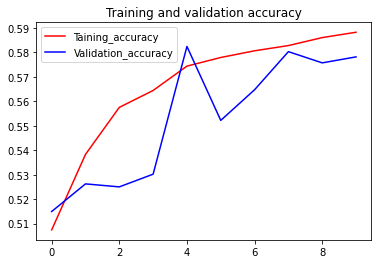

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Taining_accuracy')
plt.plot(epochs,val_acc,'b',label='Validation_accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir logs 